In [1]:
#%load_ext tensorboard
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import dataset

In [2]:
MAXLEN = 60
BATCH_SIZE = 64
files = ['texts/' + f for f in os.listdir('texts/')]

data = dataset.load_file(BATCH_SIZE, 0.05, maxlen=MAXLEN, filenames=files)

In [11]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 256
UNITS = 512

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

embedding = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)

rnn_common = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.5), merge_mode='sum', name='Common_RNN')(embedding)

rnn_niqqud = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum', name='Niqqud_RNN')(rnn_common)

dense_1 = layers.Dense(UNITS, activation='relu', kernel_regularizer=l2(5e-5), kernel_initializer='he_uniform')(rnn_niqqud)

add = layers.add([rnn_common, dense_1])

norm_1 = layers.BatchNormalization()(add)

output_niqqud = layers.Dense(data.niqqud_texts.shape[1], name='N_raw')(norm_1)
output_niqqud = layers.Softmax(name='N')(output_niqqud)

rnn_dagesh = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.2), merge_mode='sum', name='Dagesh_RNN')(rnn_common) 

output_dagesh = layers.Dense(data.dagesh_texts.shape[1], name='D_raw', kernel_initializer='he_uniform')(rnn_dagesh)
output_dagesh = layers.Softmax(name='D')(output_dagesh)

model = tf.keras.Model(inputs=[inp], outputs=[output_niqqud, output_dagesh])

plot_model(model, to_file='model.png')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(64, 60)]           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (64, 60, 256)        19200       input_2[0][0]                    
__________________________________________________________________________________________________
Common_RNN (Bidirectional)      (64, 60, 512)        2365440     embedding_1[0][0]                
__________________________________________________________________________________________________
Niqqud_RNN (Bidirectional)      (64, 60, 512)        3151872     Common_RNN[0][0]                 
____________________________________________________________________________________________

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
              metrics=['accuracy'])

def fit(EPOCHS):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

In [13]:
history = fit(EPOCHS=4)

Train on 115337 samples, validate on 6071 samples
Epoch 1/4
115337/115337 [==============================] - 239s 2ms/sample - loss: 0.4720 - N_loss: 0.3244 - D_loss: 0.1123 - N_accuracy: 0.8891 - D_accuracy: 0.9588 - val_loss: 0.2430 - val_N_loss: 0.1612 - val_D_loss: 0.0556 - val_N_accuracy: 0.9453 - val_D_accuracy: 0.9784
Epoch 2/4
115337/115337 [==============================] - 222s 2ms/sample - loss: 0.2073 - N_loss: 0.1393 - D_loss: 0.0463 - N_accuracy: 0.9526 - D_accuracy: 0.9822 - val_loss: 0.1686 - val_N_loss: 0.1154 - val_D_loss: 0.0350 - val_N_accuracy: 0.9612 - val_D_accuracy: 0.9868
Epoch 3/4
115337/115337 [==============================] - 224s 2ms/sample - loss: 0.1561 - N_loss: 0.1069 - D_loss: 0.0329 - N_accuracy: 0.9636 - D_accuracy: 0.9875 - val_loss: 0.1425 - val_N_loss: 0.0998 - val_D_loss: 0.0279 - val_N_accuracy: 0.9667 - val_D_accuracy: 0.9898
Epoch 4/4
115337/115337 [==============================] - 221s 2ms/sample - loss: 0.1307 - N_loss: 0.0903 - D_loss: 0.

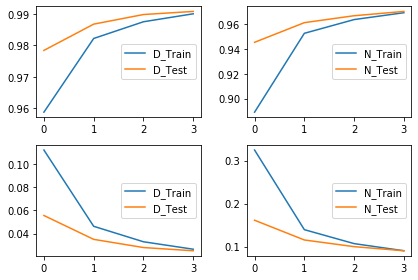

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [10]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = dataset.from_categorical(model.predict(batch))
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for a, e in zip(actual, expected):
        print(a)
        print(e)
        print()

print_predictions(1)

לְאָדָם רָשָע: הוּסַף רָשָע, וְהַמְּנָע מִן הַמִּצְווֹת. וְאַל תְּתְמָהּ וְתֹאמַר: וּמַה
לְאָדָם רָשָע: הוֹסֵף רֶשַע, וְהִמָּנַע מִן הַמִּצְווֹת. וְאַל תִּתְמַהּ וְתֹאמַר: וּמַה

חַנּוּן, שֶלֹּא אֹכַל, וְאָכַל, שֶזּוֹ אִשָּה, וְהוּא אִיש, שְאֵין לָךְ בְּיָדִי כְּלוּם,
חַנּוּן, שֶלֹּא אֹכַל, וְאָכַל, שֶזּוֹ אִשָּה, וְהוּא אִיש, שְאֵין לָךְ בְּיָדִי כְּלוּם,

שְבוּעַת הַשּוֹמְרִין. מֵאָה כּוֹר שֶלְּחִטִּים הִפְקַדְתִּי אֶצְלָךְ, וְהוּא אוֹמֵר לֹא
שְבוּעַת הַשּוֹמְרִין. מֵאָה כּוֹר שֶלְּחִטִּים הִפְקַדְתִּי אֶצְלָךְ, וְהוּא אוֹמֵר לֹא

עֵדָיו זֶה מוֹשֵךְ אֶצְלוֹ וְזֶה מוֹשֵךְ אֶצְלוֹ, עַד שְהוּא פּוֹתֵחַ אֶת פִּיו.
עֵדָיו זֶה מוֹשֵךְ אֶצְלוֹ וְזֶה מוֹשֵךְ אֶצְלוֹ, עַד שְהוּא פּוֹתֵחַ אֶת פִּיו.

כְּשֵרִים לִתֵּן לַיָּדַיִם, אַפִלּוּ חֵרֵש שוֹטֶה וְקָטָן. אִם אֵין שָם אַחֵר--מַנִּיחַ
כְּשֵרִים לִתֵּן לַיָּדַיִם, אַפִלּוּ חֵרֵש שוֹטֶה וְקָטָן. אִם אֵין שָם אַחֵר--מַנִּיחַ

יַעֲשֶה--שְלוֹשָה לַבָכִי, שִבְעָה לְהֶסְפֵּד, שְלוֹשִים יוֹם לַתַּסְפֹּרֶת וְלִשְאָר
יַעֲשֶה--שְלוֹשָה לִבְכִי, שִבְעָ